<a href="https://colab.research.google.com/github/Adarsh-Vemali/Numerical_linear_algebra/blob/main/Cora_Eigenmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# dgl Cora dataset

In [ ]:
!pip install dgl
!pip install torch torchvision

In [ ]:
from dgl.data import CoraGraphDataset
import torch

In [ ]:
dataset = CoraGraphDataset()
g = dataset[0]
num_class = dataset.num_classes

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [ ]:
print(type(dataset))
print(dataset[0])
print(num_class)

<class 'dgl.data.citation_graph.CoraGraphDataset'>
Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})
7


In [ ]:
# get node feature
feat = g.ndata['feat']

print(feat)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
# get data split
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']

print(sum(val_mask))

tensor(500)


In [ ]:
# get labels
label = g.ndata['label']

print(label)
print(torch.bincount(label))

tensor([3, 4, 4,  ..., 3, 3, 3])
tensor([351, 217, 418, 818, 426, 298, 180])


In [ ]:
g.ndata

{'feat': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'label': tensor([3, 4, 4,  ..., 3, 3, 3]), 'test_mask': tensor([False, False, False,  ...,  True,  True,  True]), 'val_mask': tensor([False, False, False,  ..., False, False, False]), 'train_mask': tensor([ True,  True,  True,  ..., False, False, False])}

# Downloaded Cora dataset

In [ ]:
import os
import networkx as nx
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
os.listdir('/content/drive/MyDrive/NLA_Project')

['nodes.csv', 'edges.csv']

In [ ]:
data_dir= '/content/drive/MyDrive/NLA_Project'

# Pytorch geometric Cora dataset

In [116]:
! pip install torch_geometric

In [117]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
%matplotlib inline

In [118]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

In [119]:
dataset = Planetoid(root=data_dir, name='Cora')
data = dataset[0]

In [120]:
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [121]:
print(f'Number of nodes: {data.num_nodes}')

Number of nodes: 2708


In [122]:
print(f'Number of edges: {data.num_edges}')
# Number of edges: 10556

Number of edges: 10556


In [123]:
print(f'Has isolated nodes: {data.has_isolated_nodes()}')  # False
print(f'Has self-loops: {data.has_self_loops()}')  # False
print(f'Is undirected: {data.is_undirected()}')  # True

Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [124]:
edge_index = data.edge_index.numpy()
print(edge_index.shape)
edge_example = edge_index[:, np.where(edge_index[0]==30)[0]]
edge_example

(2, 10556)


array([[  30,   30,   30,   30,   30,   30],
       [ 697,  738, 1358, 1416, 2162, 2343]])

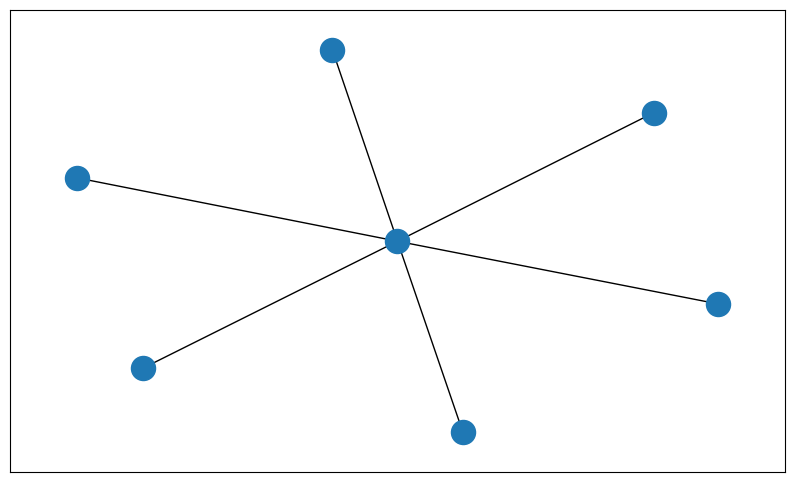

In [125]:
node_example = np.unique(edge_example.flatten())
plt.figure(figsize=(10, 6))
G = nx.Graph()
G.add_nodes_from(node_example)
G.add_edges_from(list(zip(edge_example[0], edge_example[1])))
nx.draw_networkx(G, with_labels=False)

In [126]:
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# Average node degree: 3.90

Average node degree: 3.90


In [127]:
# G = to_networkx(data, to_undirected=True)
# degrees = [val for (node, val) in G.degree()]
# display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
# print(len(degrees))
# print(sum(degrees))
# plt.figure(figsize=(10, 6))
# plt.hist(degrees, bins=50)
# plt.xlabel("node degree")
# plt.show()

In [128]:
# G = to_networkx(data, to_undirected=True)
# pos = nx.spring_layout(G, seed=42)
# cent = nx.degree_centrality(G)
# node_size = list(map(lambda x: x * 500, cent.values()))
# cent_array = np.array(list(cent.values()))
# threshold = sorted(cent_array, reverse=True)[10]
# print("threshold", threshold)
# cent_bin = np.where(cent_array >= threshold, 1, 0.1)
# plt.figure(figsize=(12, 12))
# nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
#                                cmap=plt.cm.plasma,
#                                node_color=cent_bin,
#                                nodelist=list(cent.keys()),
#                                alpha=cent_bin)
# edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
# plt.show()

In [129]:
print(f'Number of features: {data.num_node_features}')
# Number of edge features: 0

Number of features: 1433


In [130]:
print(f'Number of edge features: {data.num_edge_features}')
# Number of edge features: 0

Number of edge features: 0


In [131]:
print(f'Number of classes: {dataset.num_classes}')
# Number of classes: 7

Number of classes: 7


In [132]:
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}
data.y[:10]

tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2])

{3: 818, 4: 426, 0: 351, 2: 418, 1: 217, 5: 298, 6: 180}


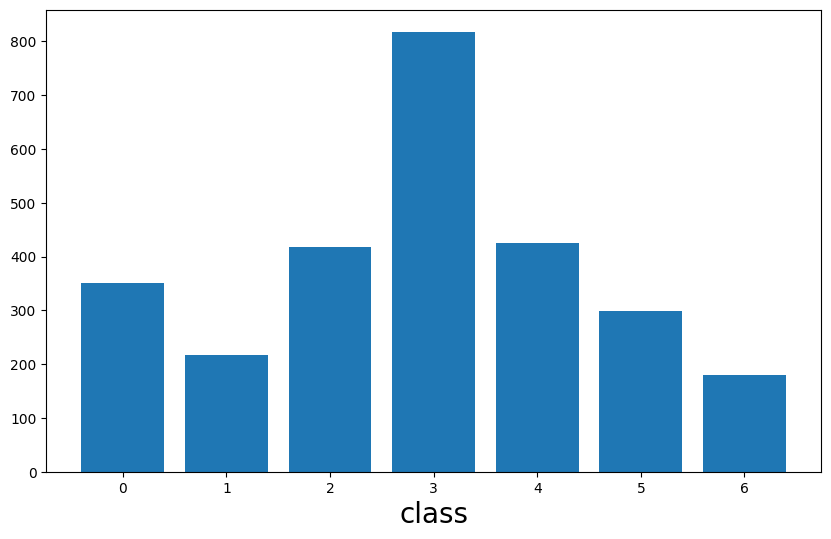

In [133]:
counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)
count = [x[1] for x in sorted(counter.items())]
plt.figure(figsize=(10, 6))
plt.bar(range(7), count)
plt.xlabel("class", size=20)
plt.show()

In [134]:
# G = to_networkx(data, to_undirected=True)
# node_color = []
# nodelist = [[], [], [], [], [], [], []]
# colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
# labels = data.y
# for n, i in enumerate(labels):
#     node_color.append(colorlist[i])
#     nodelist[i].append(n)
# pos = nx.spring_layout(G, seed = 42)
# plt.figure(figsize = (10, 10))
# labellist = list(label_dict.values())
# for num, i in enumerate(zip(nodelist, labellist)):
#     n, l = i[0], i[1]
#     nx.draw_networkx_nodes(G, pos, nodelist=n, node_size = 5, node_color = colorlist[num], label=l)
# nx.draw_networkx_edges(G, pos, width = 0.25)
# plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

Eigenmap embeddings

In [135]:
print(np.min(edge_index))

0


In [136]:
# Make Adjacency matrix of the graph

num_nodes = np.max(edge_index) +1
A = np.zeros((num_nodes,num_nodes), dtype=int)
edges=list(zip(edge_index[0], edge_index[1]))

print("Edge Index", '\n', edge_index)
print("Edges", '\n', edges)

for i in edges:
  A[i[0],i[1]]=1
  A[i[1],i[0]]=1


Edge Index 
 [[   0    0    0 ... 2707 2707 2707]
 [ 633 1862 2582 ...  598 1473 2706]]
Edges 
 [(0, 633), (0, 1862), (0, 2582), (1, 2), (1, 652), (1, 654), (2, 1), (2, 332), (2, 1454), (2, 1666), (2, 1986), (3, 2544), (4, 1016), (4, 1256), (4, 1761), (4, 2175), (4, 2176), (5, 1629), (5, 1659), (5, 2546), (6, 373), (6, 1042), (6, 1416), (6, 1602), (7, 208), (8, 269), (8, 281), (8, 1996), (9, 723), (9, 2614), (10, 476), (10, 2545), (11, 1655), (11, 1839), (12, 1001), (12, 1318), (12, 2661), (12, 2662), (13, 1701), (13, 1810), (14, 158), (14, 2034), (14, 2075), (14, 2077), (14, 2668), (15, 1090), (15, 1093), (15, 1271), (15, 2367), (16, 970), (16, 1632), (16, 2444), (16, 2642), (17, 24), (17, 927), (17, 1315), (17, 1316), (17, 2140), (18, 139), (18, 1560), (18, 1786), (18, 2082), (18, 2145), (19, 1939), (20, 1072), (20, 2269), (20, 2270), (20, 2374), (20, 2375), (21, 1043), (21, 2310), (22, 39), (22, 1234), (22, 1702), (22, 1703), (22, 2238), (23, 2159), (24, 17), (24, 201), (24, 598), (

In [137]:
print(A.sum())

10556


In [138]:
D = np.diag(A.sum(axis=1))
print(D)
print(D.shape)
print(A.shape)

[[3 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 4]]
(2708, 2708)
(2708, 2708)


In [139]:
# Unnormalized Laplacian
L = D - A
print(L)

[[ 3  0  0 ...  0  0  0]
 [ 0  3 -1 ...  0  0  0]
 [ 0 -1  5 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  4 -1]
 [ 0  0  0 ...  0 -1  4]]


In [140]:
eigenvalues, eigenvectors = np.linalg.eig(L)

eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)

In [141]:
order = np.argsort(eigenvalues)
eigenvalues = eigenvalues[order]

In [146]:
eigenvalues[0:100]

array([-5.80917786e-15, -4.28891130e-15, -3.19154202e-15, -2.45851129e-15,
       -2.03474126e-15, -2.03474126e-15, -1.57295492e-15, -1.57295492e-15,
       -1.40396528e-15, -1.40396528e-15, -1.26033845e-15, -1.21785759e-15,
       -1.12076802e-15, -1.12076802e-15, -1.10483328e-15, -9.94909007e-16,
       -8.90246172e-16, -8.90246172e-16, -8.00877587e-16, -8.00877587e-16,
       -7.10497466e-16, -7.10497466e-16, -6.25070946e-16, -5.93109935e-16,
       -5.73556972e-16, -5.51810511e-16, -4.21268934e-16, -4.08336140e-16,
       -4.08336140e-16, -3.17417349e-16, -3.17417349e-16, -1.84823217e-16,
       -1.84823217e-16, -1.29685003e-16, -1.23612000e-16, -1.23612000e-16,
       -3.45927422e-17,  8.90643668e-18,  8.90643668e-18,  1.88818671e-17,
        3.42387094e-17,  3.42387094e-17,  4.17716570e-17,  6.90895595e-17,
        6.90895595e-17,  8.36071366e-17,  1.31648284e-16,  1.31648284e-16,
        2.61221517e-16,  2.61221517e-16,  2.81238645e-16,  3.18358131e-16,
        4.21067874e-16,  

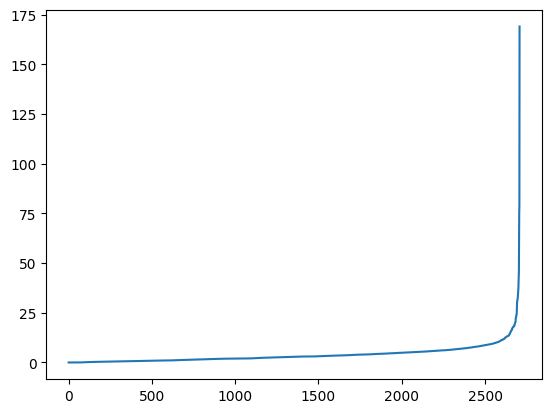

In [153]:
plt.plot(eigenvalues)

In [144]:
eigenvectors.shape

(2708, 2708)

In [173]:
embedding_size = 64
# v_0 = eigenvectors[:, order[0]]
start_index= np.where(eigenvalues>=0.001)[0][0]
v = eigenvectors[:, order[start_index:(embedding_size+ start_index)]]
print(v.shape)

(2708, 64)


In [174]:
y=data.y.numpy()

In [176]:
# tsne = TSNE()
# v_pr = tsne.fit_transform(v)
# alpha=0.7
# label_map = { l: i for i, l in enumerate(np.unique(y))}
# node_colours = [ label_map[target] for target in y]
# fig = plt.figure(figsize=(10,8))
# plt.scatter(v[:,0],
#             v[:,1],
#             c=node_colours, cmap="jet", alpha=alpha)

## Train ML classifier on the data

In [177]:
X = v
Y = y

clf = RandomForestClassifier(n_estimators=10, min_samples_leaf=4,
                             class_weight='balanced')

X_train, X_val, X_test  = X[data.train_mask] , X[data.val_mask] , X[data.test_mask]
y_train, y_val, y_test  = y[data.train_mask] , y[data.val_mask] , y[data.test_mask]


In [178]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(140, 64)
(500, 64)
(1000, 64)

(140,)
(500,)
(1000,)


In [179]:
clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', min_samples_leaf=4,
                       n_estimators=10)

In [180]:
print("score on X_train {}".format(clf.score(X_train, y_train)))
print("score on X_val {}".format(clf.score(X_val, y_val)))
print("score on X_test {}".format(clf.score(X_test, y_test)))

score on X_train 0.8571428571428571
score on X_val 0.634
score on X_test 0.626
